# An Introduction to Building Pipelines and Using Grid Searches in Scikit-learn

There are several steps to building even a basic machine learning model. Before any new data can be fed to a model, features have to be selected, data needs to be standardized and the exact type estimator to be used have to be selected and fit to training data. On top of all that, building models involve two types of parameters:  
i) **model parameters**: configuration variables internal to the model and which can be estimated from data; and,  
ii) **model hyperparameters**: configuration variables external to the model and cannot be estimated from data.[[1]](https://machinelearningmastery.com/difference-between-a-parameter-and-a-hyperparameter/)  
Hyperparameters must be supplied externally and adjusting them is a large part of developing a model. This process is often also referred to as hyperparameter tuning and involves the data scientist optimizing such parameters for performance. Throughout the model building process there are many steps where it is necessary to provide hyperparameters. 

Building a model is an iterative process. And as one would imagine, the process can easily become tedious, unwieldy and error-prone. Thankfully Scikit-Learn has a great set of tools meant to address exactly this: pipeline and gridsearch. This goal of this article is to demonstrate the usage of these tools. Before we forward it's important to mention, however, that the rest of the article is not a exercise in regression analysis. The analytical work here is simply a vehicle to demonstrate the Scikit learn tools. With that out of the way, let's get started. As always we start by importing the necessary libraries. As for libraries relevant to the subject of this article: we need ```make_pipeline``` from ```sklearn.pipeline``` to create a pipeline. The ```GridSearchCV``` method comes from ```model_selection``` module in Scikit-Learn library. We will use the Penguins dataset that ships with Seaborn.

In [79]:
import numpy as np
import pandas as pd
import seaborn as sns;
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import Ridge, Lasso

In [80]:
penguins=sns.load_dataset('penguins')

In [81]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


To illustrate the process of building a pipeline, I'll use regression to estimate body mass, which is a continuous numeric variable. Let's choose 3 columns with numerical data (```bill length```, ```bill depth```, ```flipper length```) and 1 with categorical variable (```sex```) as features. We don't need to include ```species``` as the other features already encapsulates that information. The ```sex``` column has some null values and we'll drop them.

In [82]:
penguins.dropna(inplace=True)

Let's create a feature matrix (**X**) and a matrix with target variable (**y**). Since ```sex``` is a categorical variable, we'll also need to dummify them before splitting the matrices into training and testing sets. 

In [83]:
X=penguins.drop(['island','body_mass_g'],axis=1)

In [84]:
X[['species','sex']]

,species,sex
0,Adelie,MALE
1,Adelie,FEMALE
2,Adelie,FEMALE
4,Adelie,FEMALE
5,Adelie,MALE
...,...,...
338,Gentoo,FEMALE
340,Gentoo,FEMALE
341,Gentoo,MALE
342,Gentoo,FEMALE


In [85]:
#Let's pass 'species' column to OneHotEncoder
X=pd.get_dummies(data=X,columns=['species','sex'],drop_first=True)

In [86]:
y=penguins['body_mass_g']

In [87]:
X_train,X_test,y_train,y_test=train_test_split(X,y)

In [88]:
X_train.head(2)

,bill_length_mm,bill_depth_mm,flipper_length_mm,species_Chinstrap,species_Gentoo,sex_MALE
320,48.5,15.0,219.0,0,1,0
48,36.0,17.9,190.0,0,0,0


We are finally ready to set-up a pipeline and build a model. The ```pipeline``` module in Scikit-Learn has a ```make-pipeline``` method. The first step is to to instantiate the method. We do this by passing the steps we want input data to go through in order. Once instantiated the pipeline works just like any other Scikit-Learn estimator. Here we are building a new pipeline and naming it pipe. The methods specified within ```make_pipeline``` from left to right are:  
i) ```StandardScaler()```-> We have not standardized the data before ```train_test_split```. So incoming data needs to standardized before any other transformation is performed on it.  
ii) ```SelectKBest()``` -> This method comes from ```feature_selection``` module of Scikit-learn. It selects the best features based on a scoring function (in this case, ```f_regression)```. The number of features is specified by the value of parameter ```k```. We want to try different number of features and find what works best in terms of performance. We can do that in the ```GridSearchCV``` process and will come back to it shortly.  
iii)```Ridge()``` -> This is an estimator that performs the actual regression. The name of the method refers to Tikhonov regularization (more commonly known as ridge regression) performed to reduce the effect of multicollinearity. Like the parameter k discussed previously, we want to test several different values for the various parameters of ridge regression. We do that as part of a grid search, as we discuss next.

In [89]:
pipe=make_pipeline(StandardScaler(),SelectKBest(f_regression),Ridge())

Our pipeline is now ready to be fitted. Like previously mentioned, pipeline acts just like any other estimator. It can accept parameters for every method that is part of the pipeline. A quick way to get a list of parameters that a pipeline can accept is show below:

In [90]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'selectkbest', 'ridge', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'ridge__alpha', 'ridge__copy_X', 'ridge__fit_intercept', 'ridge__max_iter', 'ridge__normalize', 'ridge__random_state', 'ridge__solver', 'ridge__tol'])

Grid search gives us the ability to search over specified values for each of the parameters listed above. We do this by creating a dictionary with names of parameters as keys and lists of parameter settings to try as values. In our example we call this dictionary ```params``` and pass it ```GridSearchCV```. Notice the parameter n_jobs. It tells Scikit-learn how many jobs to run in parallel. Setting to -1 is equivalent to instructing Scikit-learn to use all processors. Once fitted, the ```GridSearchCV``` instance ```gs``` acts just like any other estimator.

In [91]:
params={
    'selectkbest__k':[1,2,3,4,5,6],
    'ridge__fit_intercept':[True,False],
    'ridge__alpha':[5,10],
    'ridge__solver':[ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

In [92]:
gs=GridSearchCV(pipe,params,n_jobs=-1,cv=5)  

In [93]:
gs.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7fab40af3d08>)),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [5, 10],
                         'ridge__fit_intercept': [True, False],
                         'ridge__solver': ['svd', 'cholesky', 'lsqr',
                                           'sparse_cg', 'sag', 'saga'],
                         'selectkbest__k': [1, 2, 3, 4, 5, 6]})

On top of searching over all the permutations of the selected parameters, GridSearchCV performs cross-validation on training data. The default value is 5 times but we can specify any other number using the parameter ```cv```. The attribute ```cv_results_``` includes detailed results for each cross-validation run and provides a wealth of data that can be used to determine the fit and robustness of the model. Details of the permutation of parameters that performs the best is provided by the ```best_params_``` attribute.

In [94]:
df_cv_scores=pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')
df_cv_scores[['params','split0_test_score', 'split1_test_score', 'split2_test_score',\
       'split3_test_score', 'split4_test_score', 'mean_test_score',\
       'std_test_score', 'rank_test_score']].head()

,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
29,"{'ridge__alpha': 5, 'ridge__fit_intercept': Tr...",0.888430,0.885899,0.810824,0.858596,0.876535,0.864057,0.028602,1
17,"{'ridge__alpha': 5, 'ridge__fit_intercept': Tr...",0.888512,0.885923,0.810724,0.858595,0.876492,0.864049,0.028653,2
11,"{'ridge__alpha': 5, 'ridge__fit_intercept': Tr...",0.888403,0.885923,0.810724,0.858595,0.876492,0.864028,0.028635,3
5,"{'ridge__alpha': 5, 'ridge__fit_intercept': Tr...",0.888403,0.885923,0.810724,0.858595,0.876492,0.864028,0.028635,4
35,"{'ridge__alpha': 5, 'ridge__fit_intercept': Tr...",0.888431,0.885898,0.810724,0.858530,0.876500,0.864017,0.028639,5


In [95]:
gs.best_params_

{'ridge__alpha': 5,
 'ridge__fit_intercept': True,
 'ridge__solver': 'sag',
 'selectkbest__k': 6}

Finally, we can predict target values from test set by passing it's feature matrix to ```gs```. Comparing predictions with actual target values is a very effective way of visualizing and communicating performance of a model.

In [96]:
gs.score(X_test,y_test)

0.8707008994531131

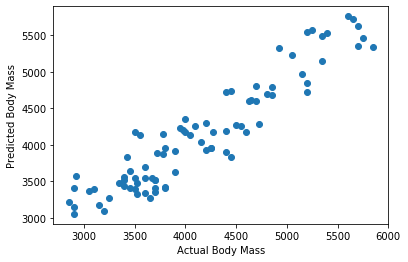

In [100]:
y_preds=gs.predict(X_test)
plt.scatter(y_test,y_preds);
plt.xlabel('Actual Body Mass')
plt.ylabel('Predicted Body Mass');
plt.savefig('predicted_vs_actual_body_mass.png')